# Set-up

In [2]:
# imports
import pandas as pd
import altair as alt


# Data Cleaning

#### First, we'll make a clean dataframe with years as the index from 1950 to 2022

In [19]:
# make the empty dataframe with years and months from 1950 to 2022 as the index
df = pd.DataFrame(index=pd.MultiIndex.from_product([range(1950, 2023), range(1, 13)], names=['year', 'month']))
# add a year_month column
df['date'] = df.index.to_series().apply(lambda x: str(x[0]) + '-' + str(x[1]).zfill(2))
# convert the year_month column to a datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

df.head(10)

date
year month           
1950 1     1950-01-01
     2     1950-02-01
     3     1950-03-01
     4     1950-04-01
     5     1950-05-01
     6     1950-06-01
     7     1950-07-01
     8     1950-08-01
     9     1950-09-01
     10    1950-10-01

#### Next, we'll need to configure the US census data by taking the overall US population and smoothing for missing years in between census reports

In [23]:
# ingest the census data
census_df = pd.read_excel(
    "00_source_data/population-change-data-table.xlsx", skiprows=3
)
# keep only census columns
census_df = census_df[
    [
        "Area",
        "1910 Census",
        "1920 Census",
        "1930 Census",
        "1940 Census",
        "1950 Census",
        "1960 Census",
        "1970 Census",
        "1980 Census",
        "1990 Census",
        "2000 Census",
        "2010 Census",
        "2020 Census",
    ]
]
# rename the mispelled United States1 to US
census_df.loc[census_df["Area"] == "United States1", "Area"] = "US"
# Pull out only the US row
census_df = census_df[census_df["Area"] == "US"]
# pivot the census data
census_df = census_df.melt(id_vars=["Area"], var_name="Year", value_name="Population")
# convert the year column to a datetime
census_df["date"] = pd.to_datetime(census_df["Year"], format="%Y Census")
# drop the Area column
census_df = census_df.drop(columns=["Area", "Year"])
# convert the population column to an integer
census_df["Population"] = census_df["Population"].astype(int)
# filter for just the years after 1949
census_df = census_df[census_df["date"] > "1949-12-31"]

census_df


,Population,date
4,151325798,1950-01-01
5,179323175,1960-01-01
6,203211926,1970-01-01
7,226545805,1980-01-01
8,248709873,1990-01-01
9,281421906,2000-01-01
10,308745538,2010-01-01
11,331449281,2020-01-01


#### Next we will pull in energy production data from government

In [5]:
energy_df = pd.read_csv("00_source_data/MER_T01_02.csv")
# split the YYYYMM column into year and month
energy_df["year"] = energy_df["YYYYMM"].apply(lambda x: int(str(x)[:4]))
energy_df["month"] = energy_df["YYYYMM"].apply(lambda x: int(str(x)[4:]))
# if the month column is 13 make it 1
energy_df.loc[energy_df["month"] == 13, "month"] = 1
# make a date column from year and month columns and add the day as 01
energy_df["date"] = pd.to_datetime(
    energy_df["year"].astype(str) + "-" + energy_df["month"].astype(str) + "-01"
)
# keep the Value and Year columns
energy_df = energy_df[["Value", "date"]]
# Rename the value column to energy_prod
energy_df = energy_df.rename(columns={"Value": "Energy_Prod"})
# drop the rows with Not Available
energy_df = energy_df[energy_df["Energy_Prod"] != "Not Available"]
# convert Energy_Prod to a float
energy_df["Energy_Prod"] = energy_df["Energy_Prod"].astype(float)
# groupby year and sum the energy
energy_df = energy_df.groupby("date").sum()

energy_df.sample(10)


,Energy_Prod
date,
1973-11-01,15.622507
2003-12-01,17.230302
2006-02-01,15.589028
1985-04-01,16.516672
2009-02-01,16.482544
1992-01-01,221.277116
1950-01-01,106.592768
1988-03-01,17.597837
1977-08-01,15.320287


#### Next is energy consumption

In [30]:
consume_df = pd.read_csv("00_source_data/MER_T01_03.csv")
# split the YYYYMM column into year and month
consume_df["year"] = consume_df["YYYYMM"].apply(lambda x: int(str(x)[:4]))
consume_df["month"] = consume_df["YYYYMM"].apply(lambda x: int(str(x)[4:]))
# if the month column is 13 make it 1
consume_df.loc[consume_df["month"] == 13, "month"] = 1
# make a date column from year and month columns and add the day as 01
consume_df["date"] = pd.to_datetime(
    consume_df["year"].astype(str) + "-" + consume_df["month"].astype(str) + "-01"
)
# keep the Value and Year columns
consume_df = consume_df[["Value", "date"]]
# Rename the value column to energy_prod
consume_df = consume_df.rename(columns={"Value": "Energy_Consume"})
# drop the rows with Not Available
consume_df = consume_df[consume_df["Energy_Consume"] != "Not Available"]
# convert Energy_Prod to a float
consume_df["Energy_Consume"] = consume_df["Energy_Consume"].astype(float)
# groupby year and sum the energy
consume_df = consume_df.groupby("date").sum()

consume_df.sample(10)


,Energy_Consume
date,
1987-06-01,18.429483
1973-08-01,18.483275
2000-10-01,22.717673
2018-04-01,23.023854
2021-08-01,24.823390
2013-04-01,21.922208
2005-07-01,24.976211
2007-08-01,25.648101
2006-08-01,25.418751


#### Now we have the vehicle efficiency data

In [33]:
veh_df = pd.read_csv("00_source_data/MER_T01_08.csv")
# subset for the rows where unit is Miles per Gallon
veh_df = veh_df[veh_df["Unit"] == "Miles per Gallon"]
# keep Descriptions where the value is All Motor Vehicles Fuel Economy
veh_df = veh_df[veh_df["Description"] == "All Motor Vehicles Fuel Economy"]
# split the YYYYMM column into two columns
veh_df["Year"] = veh_df["YYYYMM"].astype(str).str[:4]
veh_df["Month"] = veh_df["YYYYMM"].astype(str).str[4:]
# # if the month column is 13 make it 1
veh_df.loc[veh_df["Month"] == "13", "Month"] = "1"
# # make a date column from year and month columns and add the day as 01
veh_df["date"] = pd.to_datetime(
    veh_df["Year"].astype(str) + "-" + veh_df["Month"].astype(str) + "-01"
)
# keep the Value and Year columns
veh_df = veh_df[["Value", "date"]]
# # Rename the value column to Veh_MPG
veh_df = veh_df.rename(columns={"Value": "Veh_MPG"})
# # convert Veh_MPG to a float
veh_df["Veh_MPG"] = veh_df["Veh_MPG"].astype(float)
# # groupby year and take the mean
veh_df = veh_df.groupby("date").mean()

veh_df.sample(10)


,Veh_MPG
date,
1994-01-01,16.7
1950-01-01,12.8
2010-01-01,17.4
1962-01-01,12.4
1985-01-01,14.6
1960-01-01,12.4
2006-01-01,17.2
1991-01-01,16.9
2012-01-01,17.6


# Data Merging

#### Now we merge data starting with the census

<AxesSubplot: xlabel='date'>

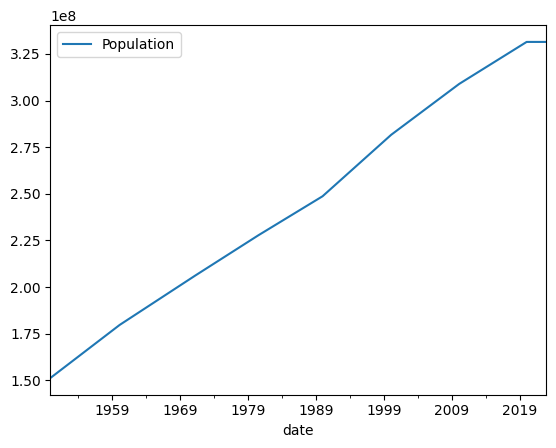

In [34]:
# merge the census data with the empty dataframe
merged_df = pd.merge(df, census_df, on="date", how="left")
# smooth the population column
merged_df["Population"] = merged_df["Population"].interpolate()
merged_df.plot(x="date", y="Population")


#### Now we add energy production data

<AxesSubplot: xlabel='date'>

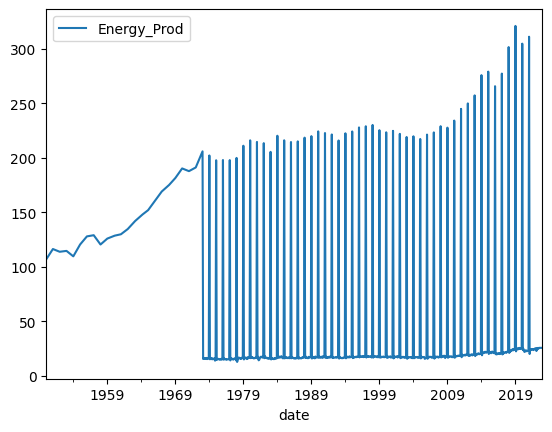

In [39]:
# merge the energy data with the merged dataframe
merged_df2 = pd.merge(merged_df, energy_df, on="date", how="left").copy()
# smooth the energy column
merged_df2["Energy_Prod"] = merged_df2["Energy_Prod"].interpolate()
merged_df2.plot(x="date", y="Energy_Prod")


#### Now we add energy consumption data

<AxesSubplot: xlabel='date'>

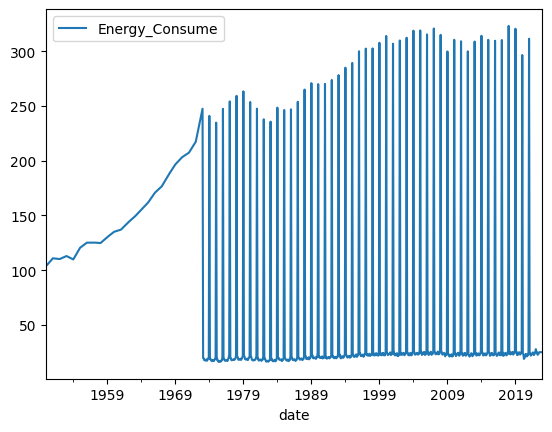

In [40]:
# merge with the consumption data
merged_df3 = pd.merge(merged_df2, consume_df, on="date", how="left").copy()
# smooth the consumption column
merged_df3["Energy_Consume"] = merged_df3["Energy_Consume"].interpolate()
merged_df3.plot(x="date", y="Energy_Consume")


#### The last merge will be the vehicle efficiency data

<AxesSubplot: xlabel='date'>

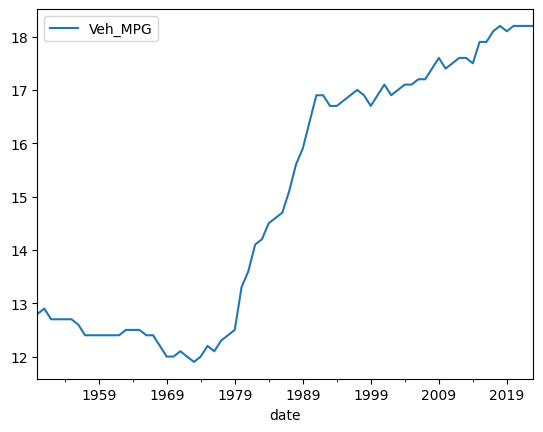

In [41]:
# merge vehicle data
merged_df4 = pd.merge(merged_df3, veh_df, on="date", how="left").copy()
# smooth the vehicle column
merged_df4["Veh_MPG"] = merged_df4["Veh_MPG"].interpolate()
merged_df4.plot(x="date", y="Veh_MPG")


# Output File as a CSV

In [42]:
# save merged df4 to a csv in the 20_clean_data_directory
merged_df4.to_csv("20_clean_data/merged_df4.csv", index=False)
